# Content :

**Part 0 : Environnement Setup**
 - <a href="#C1">Importation of libraries</a>
 - <a href="#C2">Dataset Import</a>
 
**Part 1 : Model Maintenance**

# Part 0 : Environnement Setup

# <a name="C1">Importation of libraries</a>

In [1]:
# Importing libraries
import pandas as pd
from pandas import DataFrame
import numpy as np
from datetime import datetime, timedelta

import matplotlib as mp
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn import cluster, metrics
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import SpectralClustering
from sklearn.metrics.cluster import adjusted_rand_score

In [2]:
# Displaying versions of librairies
print("pandas version : " + pd.__version__)
print("numpy version : " + np.__version__)
print("matplotlib version : " + mp.__version__)
print("seaborn version : " + sns.__version__)

pandas version : 1.4.2
numpy version : 1.21.5
matplotlib version : 3.5.1
seaborn version : 0.11.2


# <a name="C1">Dataset Import</a>

In [3]:
# Import the 2 files
customers = pd.read_csv('customers_quart.csv')
customers_cleaned = pd.read_csv('customers_cleaned.csv')

# Part 2 : Model Maintenance

In [4]:
# Visualising the end of Customers file
customers.tail(2)

,score,freight_per,delivery_per,quantity
82601,1.0,0.337273,0.431250,0.0
82602,1.0,0.556481,0.692308,0.0


In [5]:
# Visualising the end of customers_cleaned file
customers_cleaned.tail(2)

,recency,frequency,monetary,score,delivery,delivery_acc,delivery_per,quantity,order_value,freight_per,freight_value,reaction,pay_inst,pay_type,order_purchase_timestamp_max
82601,119,1,133.69,5.0,12,14,1.166667,1.0,115.00,0.139801,18.69,1,5.0,credit_card,2018-05-02 15:17:41
82602,484,1,71.56,5.0,8,16,2.000000,1.0,56.99,0.203605,14.57,1,4.0,credit_card,2017-05-02 20:18:45


In [6]:
# Limiting dataframe to purchase dates
customers_cleaned = customers_cleaned[['order_purchase_timestamp_max']]

In [7]:
# Defining max and min purchase dates
date_ref_ini = customers_cleaned['order_purchase_timestamp_max'].min()
date_ref_last = customers_cleaned['order_purchase_timestamp_max'].max()
date_ref_ini = pd.to_datetime(date_ref_ini,format='%Y-%m-%d %H:%M:%S')
date_ref_last = pd.to_datetime(date_ref_last,format='%Y-%m-%d %H:%M:%S')

In [8]:
# Adding dates to the dataset  
customers = customers.merge(customers_cleaned, left_index=True, right_index=True)
customers.head(5)

,score,freight_per,delivery_per,quantity,order_purchase_timestamp_max
0,1.000000,0.181293,0.245409,0.0,2018-05-10 10:56:27
1,0.250000,0.761299,0.465625,0.0,2018-05-07 11:11:27
2,0.166667,0.545819,0.020121,0.0,2017-03-10 21:05:03
3,0.250000,0.797727,0.194914,0.0,2017-10-12 20:29:41
4,1.000000,0.183903,0.194914,0.0,2017-11-14 19:45:42


In [9]:
# Defining a reference date corresponding to min + 12 months
date_ref_end_B0 = date_ref_ini + pd.DateOffset(months=12)
date_ref_end_B0 = pd.to_datetime(date_ref_end_B0,format='%Y-%m-%d %H:%M:%S')

In [10]:
# Training the initial M0 model to date_ref_end_B0 on customers_B0 clients
customers_B0 = customers.loc[pd.to_datetime(customers['order_purchase_timestamp_max']) <= date_ref_end_B0]
F0 = customers_B0.drop(['order_purchase_timestamp_max'], axis=1).values
scaler = StandardScaler()
F0_std = scaler.fit_transform(F0)
modele = cluster.KMeans(n_clusters=6)
M0 = modele.fit(F0_std)
C0 = M0.labels_

In [11]:
# Initialising before loop
i = -1
date_limit = date_ref_end_B0
ARI_scores = []
ARI_results = pd.DataFrame()

# Training the initial Mi model to date_ref_end_Bi on customers_Bi clients to get the clusters Ci_new.
# Comparing to clusters Ci_init that matches the M0 model's prediction about customers_Bi clients
while date_limit < date_ref_last:
    i +=1
    customers_Bi = customers.loc[pd.to_datetime(customers['order_purchase_timestamp_max']) <= date_limit]
    Fi = customers_Bi.drop(['order_purchase_timestamp_max'], axis=1).values
    Fi_std = scaler.fit_transform(Fi)
    model = cluster.KMeans(n_clusters=6)
    Mi = model.fit(Fi_std)
    Ci_new = Mi.labels_
    
    Ci_init = M0.predict(Fi_std)
    
    ARI_score = metrics.adjusted_rand_score(Ci_new, Ci_init)
    ARI_scores.append(ARI_score)
     
    date_limit += timedelta(days=30)

In [12]:
# Observing results of comparaison
ARI_scores

[0.9990720050745283,
 0.9911253846961139,
 0.9645505390736551,
 0.9614476202095069,
 0.95994317664227,
 0.9486190387190295,
 0.7122556028915337,
 0.9512627450280591,
 0.9587430667691801,
 0.9749386523979774,
 0.9876701695150478]

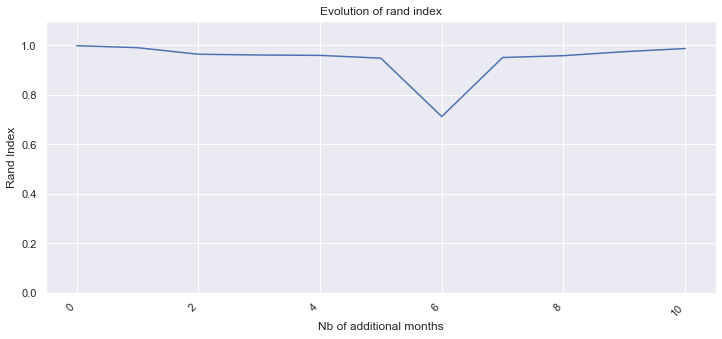

In [13]:
# Visualising results of comparaison
fig = plt.figure(figsize=(12,5))

rands = []
   
plt.plot(ARI_scores)
plt.title('Evolution of rand index')
plt.xlabel('Nb of additional months')
plt.ylabel('Rand Index')
plt.xticks(rotation='45', horizontalalignment="right")
plt.ylim((0,1.1))
plt.show()

The end of simulation notebook